#### Importing the required libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/customer_features.csv
/kaggle/input/last_month_assortment.csv
/kaggle/input/next_purchase_order.csv
/kaggle/input/original_purchase_order.csv
/kaggle/input/next_month_assortment.csv
/kaggle/input/product_features.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
pd.set_option('display.max_columns', 100)

#### Reading the provided files into dataframes

In [3]:
customer_features_df = pd.read_csv("/kaggle/input/customer_features.csv")
last_month_assortment_df = pd.read_csv("/kaggle/input/last_month_assortment.csv")
next_month_assortment_df = pd.read_csv("/kaggle/input/next_month_assortment.csv")
next_purchase_order_df = pd.read_csv("/kaggle/input/next_purchase_order.csv")
original_purchase_order_df = pd.read_csv("/kaggle/input/original_purchase_order.csv")
product_features_df = pd.read_csv("/kaggle/input/product_features.csv")

#### One by one we will try to understand the contents of each file and check for null value deletion/imputation etc

In [4]:
customer_features_df.head()

,customer_id,age_bucket,is_returning_customer,favorite_genres
0,1000078,46-55,True,"['Classic', 'History', 'Self-Help', 'Romance',..."
1,1000102,46-55,True,"['Beach-Read', 'Pop-Sci', 'Pop-Psychology', 'B..."
2,1000185,46-55,True,"['Romance', 'Self-Help', 'Beach-Read', 'Pop-Ps..."
3,1000423,26-35,True,"['Classic', 'Drama']"
4,1000696,66+,True,"['Drama', 'Thriller', 'Sci-Fi', 'Romance', 'Hi..."


#### Problem statement definition of this file
customer_features: Customer features generated by the profiles that customers fill
out with us indexed by a unique customer ID.

In [5]:
customer_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 4 columns):
customer_id              12000 non-null int64
age_bucket               11500 non-null object
is_returning_customer    12000 non-null bool
favorite_genres          12000 non-null object
dtypes: bool(1), int64(1), object(2)
memory usage: 293.0+ KB


In [6]:
# Checking the percentage of missing values in this file
col_list = customer_features_df.columns

for col_name in customer_features_df.columns:
    missing_percent = round(100* ((customer_features_df[col_name].isnull()) | (customer_features_df[col_name].astype(str) == 'Select')).sum() /len(customer_features_df.index) , 2)
    print(col_name + " - " + str(missing_percent))

customer_id - 0.0
age_bucket - 4.17
is_returning_customer - 0.0
favorite_genres - 0.0


age_bucket column is having 500 missing values. We wont impute/delete these records as of now.

#### We will convert favourite genres into a seperate column each for each of the unique genres
'Self-Help', 'Biography', 'History', 'Thriller', 'Sci-Fi','Romance', 'Pop-Psychology', 'Beach-Read', 'Drama', 'Classic','Pop-Sci'

In [7]:
customer_features_df['Likes_Self_Help'] = 0
customer_features_df['Likes_Biography'] = 0
customer_features_df['Likes_History'] = 0
customer_features_df['Likes_Thriller'] = 0
customer_features_df['Likes_Sci_Fi'] = 0
customer_features_df['Likes_Romance'] = 0
customer_features_df['Likes_Pop_Psychology'] = 0
customer_features_df['Likes_Beach_Read'] = 0
customer_features_df['Likes_Drama'] = 0
customer_features_df['Likes_Classic'] = 0
customer_features_df['Likes_Pop_Sci'] = 0

In [8]:
customer_features_df['Likes_Self_Help'] = customer_features_df.apply(lambda row: 1 if 'Self-Help' in str(row.favorite_genres) else 0,axis=1)
customer_features_df['Likes_Biography'] = customer_features_df.apply(lambda row: 1 if 'Biography' in str(row.favorite_genres) else 0,axis=1)
customer_features_df['Likes_History'] = customer_features_df.apply(lambda row: 1 if 'History' in str(row.favorite_genres) else 0,axis=1)
customer_features_df['Likes_Thriller'] = customer_features_df.apply(lambda row: 1 if 'Thriller' in str(row.favorite_genres) else 0,axis=1)
customer_features_df['Likes_Sci_Fi'] = customer_features_df.apply(lambda row: 1 if 'Sci-Fi' in str(row.favorite_genres) else 0,axis=1)
customer_features_df['Likes_Romance'] = customer_features_df.apply(lambda row: 1 if 'Romance' in str(row.favorite_genres) else 0,axis=1)
customer_features_df['Likes_Pop_Psychology'] = customer_features_df.apply(lambda row: 1 if 'Pop-Psychology' in str(row.favorite_genres) else 0,axis=1)
customer_features_df['Likes_Beach_Read'] = customer_features_df.apply(lambda row: 1 if 'Beach-Read' in str(row.favorite_genres) else 0,axis=1)
customer_features_df['Likes_Drama'] = customer_features_df.apply(lambda row: 1 if 'Drama' in str(row.favorite_genres) else 0,axis=1)
customer_features_df['Likes_Classic'] = customer_features_df.apply(lambda row: 1 if 'Classic' in str(row.favorite_genres) else 0,axis=1)
customer_features_df['Likes_Pop_Sci'] = customer_features_df.apply(lambda row: 1 if 'Pop-Sci' in str(row.favorite_genres) else 0,axis=1)

In [9]:
customer_features_df.head()

,customer_id,age_bucket,is_returning_customer,favorite_genres,Likes_Self_Help,Likes_Biography,Likes_History,Likes_Thriller,Likes_Sci_Fi,Likes_Romance,Likes_Pop_Psychology,Likes_Beach_Read,Likes_Drama,Likes_Classic,Likes_Pop_Sci
0,1000078,46-55,True,"['Classic', 'History', 'Self-Help', 'Romance',...",1,0,1,1,1,1,1,1,0,1,1
1,1000102,46-55,True,"['Beach-Read', 'Pop-Sci', 'Pop-Psychology', 'B...",1,1,0,0,1,0,1,1,1,0,1
2,1000185,46-55,True,"['Romance', 'Self-Help', 'Beach-Read', 'Pop-Ps...",1,0,0,0,0,1,1,1,0,0,0
3,1000423,26-35,True,"['Classic', 'Drama']",0,0,0,0,0,0,0,0,1,1,0
4,1000696,66+,True,"['Drama', 'Thriller', 'Sci-Fi', 'Romance', 'Hi...",0,1,1,1,1,1,0,1,1,0,0


In [10]:
customer_features_df.loc[customer_features_df.Likes_Self_Help==1].age_bucket.value_counts()

46-55    1240
36-45    1058
56-65    1036
66+       987
26-35     494
18-25     315
0-17       25
Name: age_bucket, dtype: int64

In [11]:
customer_features_df.loc[customer_features_df.Likes_Biography==1].age_bucket.value_counts()

46-55    1190
56-65    1073
36-45    1033
66+       984
26-35     475
18-25     321
0-17       26
Name: age_bucket, dtype: int64

In [12]:
customer_features_df.loc[customer_features_df.Likes_History==1].age_bucket.value_counts()

46-55    1225
56-65    1064
36-45    1058
66+      1003
26-35     483
18-25     333
0-17       31
Name: age_bucket, dtype: int64

In [13]:
customer_features_df.loc[customer_features_df.Likes_Thriller==1].age_bucket.value_counts()

46-55    1232
56-65    1064
36-45    1044
66+       997
26-35     483
18-25     338
0-17       27
Name: age_bucket, dtype: int64

In [14]:
customer_features_df.loc[customer_features_df.Likes_Sci_Fi==1].age_bucket.value_counts()

46-55    1254
56-65    1075
36-45    1054
66+       980
26-35     493
18-25     330
0-17       26
Name: age_bucket, dtype: int64

In [15]:
customer_features_df.loc[customer_features_df.Likes_Romance==1].age_bucket.value_counts()

46-55    1234
36-45    1085
56-65    1074
66+       993
26-35     469
18-25     313
0-17       26
Name: age_bucket, dtype: int64

In [16]:
customer_features_df.loc[customer_features_df.Likes_Pop_Psychology==1].age_bucket.value_counts()

46-55    1225
56-65    1104
36-45    1076
66+       972
26-35     490
18-25     320
0-17       25
Name: age_bucket, dtype: int64

In [17]:
customer_features_df.loc[customer_features_df.Likes_Beach_Read==1].age_bucket.value_counts()

46-55    1244
36-45    1071
56-65    1045
66+      1007
26-35     471
18-25     328
0-17       28
Name: age_bucket, dtype: int64

In [18]:
customer_features_df.loc[customer_features_df.Likes_Drama==1].age_bucket.value_counts()


46-55    1276
36-45    1081
56-65    1039
66+      1007
26-35     467
18-25     322
0-17       25
Name: age_bucket, dtype: int64

In [19]:
customer_features_df.loc[customer_features_df.Likes_Classic==1].age_bucket.value_counts()


46-55    1224
56-65    1075
36-45    1039
66+       994
26-35     467
18-25     310
0-17       23
Name: age_bucket, dtype: int64

In [20]:
customer_features_df.loc[customer_features_df.Likes_Pop_Sci==1].age_bucket.value_counts()


46-55    1198
36-45    1078
56-65    1048
66+       987
26-35     464
18-25     315
0-17       33
Name: age_bucket, dtype: int64

Imputing Age Bracket based on Genre doesnt look like a good option, after calculating revenue etc, moving ahead with classification, we wil delete the missing values

In [21]:
original_purchase_order_df.head()

,product_id,quantity_purchased,cost_to_buy,retail_value
0,1769808,77,2.20,16.67
1,1896283,67,1.46,9.59
2,1889979,80,2.06,13.36
3,1341288,85,1.25,6.57
4,1666328,60,1.51,10.49


#### Problem statement definition of this file
original_purchase_order: Quantity of books originally purchased indexed by a
unique product ID.

In [22]:
original_purchase_order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
product_id            1000 non-null int64
quantity_purchased    1000 non-null int64
cost_to_buy           1000 non-null float64
retail_value          1000 non-null float64
dtypes: float64(2), int64(2)
memory usage: 31.3 KB


No missing values in this file.

#### As per Problem Statement:
As a company we have to buy our books ahead of time. We took out a loan last month to buy our
original batch of books. The value of the loan was the total cost of all the books that we bought. 

From my understanding cost_to_buy and retail_value for 1 quantity of the product

So below would be the loan amount taken:

In [23]:
original_purchase_order_df['total_cost_to_buy'] = original_purchase_order_df.cost_to_buy * original_purchase_order_df.quantity_purchased

In [24]:
original_purchase_order_df.head()

,product_id,quantity_purchased,cost_to_buy,retail_value,total_cost_to_buy
0,1769808,77,2.20,16.67,169.40
1,1896283,67,1.46,9.59,97.82
2,1889979,80,2.06,13.36,164.80
3,1341288,85,1.25,6.57,106.25
4,1666328,60,1.51,10.49,90.60


In [25]:
next_purchase_order_df.head()

,product_id,quantity_purchased,cost_to_buy,retail_value
0,1479507,39,1.82,12.68
1,1681385,55,1.73,12.88
2,1771749,37,1.26,10.38
3,1605149,49,1.47,11.27
4,1861356,34,1.98,10.41


#### Problem statement definition of this file:

next_purchase_order: Planned quantity of books to purchase at the end of next
month indexed by a unique product ID.

In [26]:
next_purchase_order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
product_id            300 non-null int64
quantity_purchased    300 non-null int64
cost_to_buy           300 non-null float64
retail_value          300 non-null float64
dtypes: float64(2), int64(2)
memory usage: 9.5 KB


No missing values in this file as well.

In [27]:
next_purchase_order_df['total_cost_to_buy'] = next_purchase_order_df.quantity_purchased * next_purchase_order_df.cost_to_buy

In [28]:
product_features_df.head()

,product_id,length,difficulty,fiction,genre
0,1769808,148,3,False,Self-Help
1,1896283,161,5,False,Biography
2,1889979,296,4,False,History
3,1341288,551,4,True,Thriller
4,1666328,623,-1,True,Sci-Fi


#### Problem statement definition of this file:

Product features that we have generated from our knowledge of
our books indexed by a unique product ID.

In [29]:
product_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
product_id    1000 non-null int64
length        1000 non-null int64
difficulty    1000 non-null int64
fiction       1000 non-null bool
genre         1000 non-null object
dtypes: bool(1), int64(3), object(1)
memory usage: 32.3+ KB


No missing values here.

In [30]:
last_month_assortment_df.head()

,customer_id,product_id,purchased
0,1000078,1730073,False
1,1000078,1470520,False
2,1000078,1861356,False
3,1000078,1240824,True
4,1000078,1155460,False


We will later merge this data frame with original_purchase_order_df, to figure out the revenue/profit for the purchases the user made.

#### Problem statement definition of this file:

Data on which books were sent to which customers and
whether or not the customer purchased the book. There is no index.

In [31]:
last_month_assortment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 3 columns):
customer_id    36000 non-null int64
product_id     36000 non-null int64
purchased      36000 non-null bool
dtypes: bool(1), int64(2)
memory usage: 597.7 KB


No missing values here.

In [32]:
next_month_assortment_df.head()

,customer_id,product_id
0,1600785,1443029
1,1600785,1164138
2,1600785,1636511
3,1600785,1832547
4,1600785,1237420


#### Problem statement definition of this file:

next_month_assortment: Data on which books will be sent to which customers next
month. There is no index.

In [33]:
next_month_assortment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56400 entries, 0 to 56399
Data columns (total 2 columns):
customer_id    56400 non-null int64
product_id     56400 non-null int64
dtypes: int64(2)
memory usage: 881.3 KB


No missing values here.

#### Problem formulation

Assume we are a mail-delivery book startup. 

You fill out a profile with us about your book
preferences, and we will send you 5 books each month for free. Whatever you like you keep and pay
for, and whatever you don't like you send back.

As a company we have to buy our books ahead of time. We took out a loan last month to buy our
original batch of books. The value of the loan was the total cost of all the books that we bought. 

We made some money back through customers buying our books last month. 

Next month, we know which books we will be sending to which customers, but we do not know who will buy what books. 

It costs 0.60/book each way for shipping books to and from customers. 

The question for you to answer
is:
Will we be able to both pay back our loan and afford our next book purchase order?





#### As per my understanding, below are the steps to come to a solution. 
#### Changes will be made to the aproach if I find any data different from my assumptions.

1. First we have to solve the classification problem, whether each of the customer will buy the book or not buy the book in next_month_assortment.

This would be based on the customers past purchases in last_month_assortment_df and also based on customers genre interests, age etc. 

For the customers who are new in next_month_assortment it would be based only on latter as there would not be any past purchase info.

2. Based on the predictions in point 1, revenue needs to be calculated for the next_month_assortment based on which we can answer the question whether we will be able to both pay back our loan and afford our next book purchase order.

#### Total spending for all books of the original purchase order which is also equal to the loan amount.

In [34]:
#Total Loan Amount
initial_loan_amount = round(original_purchase_order_df.total_cost_to_buy.sum(),2)
initial_loan_amount

135546.42

#### Total spending that will be required for the next purchase order:

In [35]:
total_spending_reqd_next_mnth_purchase = round(next_purchase_order_df.total_cost_to_buy.sum(),2)
total_spending_reqd_next_mnth_purchase

24155.51

#### Total revenue earned in the last_month_assortment_df

In [36]:
df_temp = pd.merge(last_month_assortment_df, original_purchase_order_df, how='inner', on='product_id')

In [37]:
df_temp['purchased_price'] = df_temp.apply(lambda row: row.retail_value if row.purchased else 0, axis=1)

In [38]:
df_temp['send_shipping_cost'] = 0.60

In [39]:
df_temp['return_shipping_cost'] = df_temp.purchased.apply(lambda x: 0.60 if not x else 0)

In [40]:
total_revenue_last_mnth_assortment = df_temp.purchased_price.sum() - (df_temp.send_shipping_cost + df_temp.return_shipping_cost).sum()
total_revenue_last_mnth_assortment

116024.76

#### Profit Earned Last Month = Total Revenue last month - Book Purchase costs

In [41]:
profit_earned_last_month = round( 116024.76 - 135546.42, 2)
profit_earned_last_month

-19521.66

In [42]:
loan_pending = round(135546.42 - 116024.76 , 2)
loan_pending


19521.66

#### Work on the classification problem whether customers will buy next assortment books or not

In [43]:
# Defining the map function
def binary_map(x):
    return x.map({True: 1, False: 0})

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_temp2[['retail_value','length','difficulty']] = scaler.fit_transform(X[['retail_value','length','difficulty']])

df_temp2.head()

In [44]:
last_month_assortment_df.head()

,customer_id,product_id,purchased
0,1000078,1730073,False
1,1000078,1470520,False
2,1000078,1861356,False
3,1000078,1240824,True
4,1000078,1155460,False


In [45]:
customer_features_df.head()

,customer_id,age_bucket,is_returning_customer,favorite_genres,Likes_Self_Help,Likes_Biography,Likes_History,Likes_Thriller,Likes_Sci_Fi,Likes_Romance,Likes_Pop_Psychology,Likes_Beach_Read,Likes_Drama,Likes_Classic,Likes_Pop_Sci
0,1000078,46-55,True,"['Classic', 'History', 'Self-Help', 'Romance',...",1,0,1,1,1,1,1,1,0,1,1
1,1000102,46-55,True,"['Beach-Read', 'Pop-Sci', 'Pop-Psychology', 'B...",1,1,0,0,1,0,1,1,1,0,1
2,1000185,46-55,True,"['Romance', 'Self-Help', 'Beach-Read', 'Pop-Ps...",1,0,0,0,0,1,1,1,0,0,0
3,1000423,26-35,True,"['Classic', 'Drama']",0,0,0,0,0,0,0,0,1,1,0
4,1000696,66+,True,"['Drama', 'Thriller', 'Sci-Fi', 'Romance', 'Hi...",0,1,1,1,1,1,0,1,1,0,0


In [46]:
last_month_assortment_df.customer_id.nunique()

7200

In [47]:
next_month_assortment_df.customer_id.nunique()

11280

In [48]:
last_month_assortment_df.product_id.nunique()

1000

In [49]:
next_month_assortment_df.product_id.nunique()

1000

In [50]:
len(product_features_df)

1000

#### Creating user and item correlation matrix. for creating user correlation matrix, considering both last_month_assortment_df and next_month_assortment_df as some extra users are there in next_month_assortment_df.
#### Since purchased or not is not available in next assortment, as we want to predict that, will consider purchased as 0 in that case.

In [51]:
last_month_assortment_df.head()

,customer_id,product_id,purchased
0,1000078,1730073,False
1,1000078,1470520,False
2,1000078,1861356,False
3,1000078,1240824,True
4,1000078,1155460,False


In [52]:
next_month_assortment_df1 = next_month_assortment_df
next_month_assortment_df1['purchased'] = False
df_temp3 = pd.concat([last_month_assortment_df, next_month_assortment_df1], axis = 0)
df_temp3.purchased = df_temp3.purchased.apply(lambda x: 1 if x else 0)


In [53]:
df_temp3 = df_temp3.pivot_table(
    index='customer_id',
    columns='product_id',
    values='purchased'
).fillna(0)

In [54]:
len(df_temp3)

12000

In [55]:
len(customer_features_df)

12000

In [56]:
df_temp3 = pd.merge( df_temp3, customer_features_df,how='inner',on='customer_id')
df_temp3.drop('favorite_genres',axis=1,inplace=True)
df_temp3.is_returning_customer = df_temp3.is_returning_customer.apply(lambda x: 1 if x else 0)
dummy1 = pd.get_dummies(df_temp3[['age_bucket']], drop_first=True)
df_temp3 = pd.concat([df_temp3, dummy1], axis=1)
df_temp3.drop('age_bucket',axis=1,inplace=True)
df_temp3.head()

,customer_id,1003455,1004302,1007659,1008476,1009975,1010420,1014238,1014695,1014973,1016107,1016253,1017884,1019466,1020542,1023104,1023182,1023796,1023809,1025311,1025861,1027512,1028567,1029311,1030034,1032843,1032950,1032956,1034822,1037721,1038240,1039356,1039653,1039686,1040009,1040065,1040387,1040983,1042645,1042919,1043248,1046315,1046892,1048469,1048650,1049883,1051590,1051609,1051916,1054441,...,1973979,1974874,1974901,1976314,1977053,1978105,1980468,1980684,1981204,1982400,1982635,1983714,1985586,1985971,1986746,1987773,1988675,1989316,1989539,1989809,1994245,1994284,1995072,1995596,1996282,1996545,1996584,1996669,1996925,1997181,1997722,1998756,is_returning_customer,Likes_Self_Help,Likes_Biography,Likes_History,Likes_Thriller,Likes_Sci_Fi,Likes_Romance,Likes_Pop_Psychology,Likes_Beach_Read,Likes_Drama,Likes_Classic,Likes_Pop_Sci,age_bucket_18-25,age_bucket_26-35,age_bucket_36-45,age_bucket_46-55,age_bucket_56-65,age_bucket_66+
0,1000078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,1,1,1,1,1,0,1,1,0,0,0,1,0,0
1,1000102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0,0,1,0,1,1,1,0,1,0,0,0,1,0,0
2,1000185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0
3,1000423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0
4,1000696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,1


#### Find the similarity between users based on purchases and user properties

In [57]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = pairwise_distances(df_temp3, metric='euclidean')


In [58]:
user_correlation_df = pd.DataFrame(user_correlation)

In [59]:
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,11950,11951,11952,11953,11954,11955,11956,11957,11958,11959,11960,11961,11962,11963,11964,11965,11966,11967,11968,11969,11970,11971,11972,11973,11974,11975,11976,11977,11978,11979,11980,11981,11982,11983,11984,11985,11986,11987,11988,11989,11990,11991,11992,11993,11994,11995,11996,11997,11998,11999
0,0.000000,24.166092,107.032705,345.018840,618.009709,707.004950,838.004177,1066.005159,1094.004113,1160.005172,1170.004273,1304.002684,1310.003817,1341.002610,1405.004626,1438.004520,1474.001018,1609.004040,1632.003983,1634.002142,1716.002622,1735.002882,1807.001937,1851.003512,2007.003488,2117.003070,2145.002331,2256.002881,2284.001313,2423.001238,2514.002983,2523.001784,2644.002269,2647.002078,2701.001851,2713.001474,2860.002622,3017.001492,3108.000965,3143.001273,3187.001569,3272.001681,3303.001968,3441.001308,3442.001888,3525.001418,3598.000973,3648.001371,3679.000951,3743.001202,...,995200.000004,995212.000003,995237.000005,995309.000004,995375.000006,995428.000004,995462.000006,995486.000006,995625.000003,995683.000003,995993.000004,996057.000006,996265.000004,996535.000004,996588.000006,996748.000005,996919.000007,997010.000005,997018.000004,997020.000003,997024.000004,997026.000003,997088.000006,997089.000006,997177.000004,997327.000003,997652.000003,997672.000007,997729.000004,997744.000005,997771.000003,997805.000003,997883.000006,997904.000003,997934.000003,998275.000006,998344.000007,998484.000003,998658.000003,998782.000004,998857.000004,998947.000006,998951.000004,998996.000005,999012.000003,999300.000004,999325.000004,999482.000004,999514.000003,999515.000004
1,24.166092,0.000000,83.042158,321.017133,594.010101,683.006589,814.004300,1042.004319,1070.005140,1136.005282,1146.005236,1280.002734,1286.003110,1317.003417,1381.003983,1414.003182,1450.003103,1585.004101,1608.003420,1610.002795,1692.003842,1711.003507,1783.003085,1827.003010,1983.003026,2093.003106,2121.002357,2232.002464,2260.001327,2399.002084,2490.002610,2499.002201,2620.001908,2623.001716,2677.001494,2689.001859,2836.002292,2993.001838,3084.001297,3119.001924,3163.001265,3248.001693,3279.001677,3417.001610,3418.001609,3501.001428,3574.001259,3624.001380,3655.001231,3719.001210,...,995176.000005,995188.000004,995213.000004,995285.000004,995351.000006,995404.000004,995438.000006,995462.000005,995601.000005,995659.000003,995969.000006,996033.000006,996241.000004,996511.000005,996564.000005,996724.000004,996895.000005,996986.000005,996994.000003,996996.000004,997000.000004,997002.000003,997064.000005,997065.000003,997153.000004,997303.000005,997628.000004,997648.000005,997705.000004,997720.000005,997747.000004,997781.000004,997859.000005,997880.000004,997910.000005,998251.000005,998320.000004,998460.000004,998634.000004,998758.000004,998833.000005,998923.000005,998927.000004,998972.000006,998988.000004,999276.000005,999301.000003,999458.000003,999490.000004,999491.000003
2,107.032705,83.042158,0.000000,238.021007,511.012720,600.006667,731.006840,959.007299,987.004053,1053.005223,1063.004233,1197.004177,1203.003741,1234.004862,1298.003852,1331.003005,1367.002926,1502.003995,1525.002623,1527.003274,1609.003729,1628.003378,1700.003529,1744.002294,1900.002368,2010.001990,2038.001227,2149.002792,2177.002067,2316.002375,2407.002077,2416.002070,2537.002956,2540.001969,2594.001349,2606.002494,2753.001816,2910.001375,3001.000833,3036.002141,3080.002110,3165.001896,3196.001252,3334.002100,3335.001499,3418.001609,3491.001432,3541.001553,3572.001120,3636.001650,...,995093.000003,995105.000006,995130.000003,995202.000006,995268.000004,995321.000006,995355.000004,995379.000003,995518.000005,995576.000005,995886.000004,995950.000004,996158.000004,996428.000003,996481.000004,996641.000004,996812.000005,996903.000004,996911.000004,996913.000006,996917.000006,996919.000005,996981.000007,996982.000004,997070.000006,997220.000006,997545

#### Find similarity between products 

In [60]:
product_features_df.head()

,product_id,length,difficulty,fiction,genre
0,1769808,148,3,False,Self-Help
1,1896283,161,5,False,Biography
2,1889979,296,4,False,History
3,1341288,551,4,True,Thriller
4,1666328,623,-1,True,Sci-Fi


In [61]:
product_features_df.product_id.nunique()

1000

In [62]:
original_purchase_order_df.head()

,product_id,quantity_purchased,cost_to_buy,retail_value,total_cost_to_buy
0,1769808,77,2.20,16.67,169.40
1,1896283,67,1.46,9.59,97.82
2,1889979,80,2.06,13.36,164.80
3,1341288,85,1.25,6.57,106.25
4,1666328,60,1.51,10.49,90.60


In [63]:
original_purchase_order_df.product_id.nunique()

1000

In [64]:
df_temp4 = pd.merge(product_features_df,original_purchase_order_df,how='inner',on='product_id')
df_temp4.drop(['quantity_purchased','cost_to_buy','total_cost_to_buy'],axis=1,inplace=True)
df_temp4.fiction = df_temp4.fiction.apply(lambda x: 1 if x else 0)
dummy1 = pd.get_dummies(df_temp4[['genre']], drop_first=True)
df_temp4 = pd.concat([df_temp4, dummy1], axis=1)
df_temp4.drop('genre',axis=1,inplace=True)

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_temp4[['retail_value','length','difficulty']] = scaler.fit_transform(df_temp4[['retail_value','length','difficulty']])

In [66]:
df_temp4.head()

,product_id,length,difficulty,fiction,retail_value,genre_Biography,genre_Classic,genre_Drama,genre_History,genre_Pop-Psychology,genre_Pop-Sci,genre_Romance,genre_Sci-Fi,genre_Self-Help,genre_Thriller
0,1769808,-0.231280,0.175902,0,1.536029,0,0,0,0,0,0,0,0,1,0
1,1896283,-0.231221,1.336969,0,-0.819130,1,0,0,0,0,0,0,0,0,0
2,1889979,-0.230601,0.756435,0,0.434959,0,0,0,1,0,0,0,0,0,0
3,1341288,-0.229431,0.756435,1,-1.823731,0,0,0,0,0,0,0,0,0,1
4,1666328,-0.229100,-2.146232,1,-0.519745,0,0,0,0,0,0,0,1,0,0


In [67]:
# User Similarity Matrix
item_correlation = pairwise_distances(df_temp4, metric='euclidean')

In [68]:
item_correlation_df = pd.DataFrame(item_correlation)

In [69]:
item_correlation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 1000 entries, 0 to 999
dtypes: float64(1000)
memory usage: 7.6 MB


In [70]:
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.000000,126475.000035,120171.000015,428520.000017,103480.000061,135372.000016,754835.000000,118986.000032,691088.000018,453942.000016,441388.000015,125046.000037,685645.000004,173897.000016,38337.000078,84325.000039,344074.000017,745999.000018,227117.000053,255984.000022,554458.000005,515874.000004,69664.000060,711987.000009,62690.000000,61823.000126,31979.000176,86675.000015,39821.000148,227293.000011,546.006408,376360.000004,353861.000007,173694.000000,648970.000004,83587.000053,18865.000151,484915.000004,131368.000031,687759.000003,488284.000026,180146.000031,566009.000008,86751.000055,155734.000011,410258.000009,183023.000016,320970.000008,160543.000047,390950.000003,...,661398.000008,330515.000011,179354.000093,439151.000005,483370.000004,279469.000006,107498.000068,269552.000008,167213.000011,132543.000012,50143.000248,267096.000021,426044.000010,39735.000100,167110.000028,497139.000006,296904.000004,550255.000003,141477.000008,210427.000005,143459.000034,650510.000009,47645.000070,422319.000014,115662.000020,493212.000004,239829.000013,144914.000023,197985.000030,43407.000073,424954.000019,702595.000007,129061.000035,726889.000005,145772.000012,616636.000004,713531.000002,197181.000012,48100.000039,218867.000016,552861.000013,62913.000029,88423.000028,713666.000006,127568.000022,10779.000272,469257.000005,481199.000007,414998.000005,533086.000008
1,126475.000035,0.000000,6304.000310,554995.000004,229955.000033,8897.000779,881310.000004,7489.000336,817563.000020,580417.000003,567863.000012,251521.000009,812120.000003,47422.000051,164812.000020,210800.000012,470549.000000,872474.000018,100642.000152,382459.000005,680933.000002,642349.000007,56811.000018,838462.000002,63785.000074,64652.000118,94496.000045,213150.000020,166296.000011,353768.000017,125929.000009,502835.000008,480336.000006,300169.000016,775445.000007,42888.000028,107610.000016,611390.000005,257843.000006,814234.000003,614759.000019,53671.000043,692484.000002,213226.000004,282209.000024,536733.000003,309498.000009,447445.000005,287018.000010,517425.000006,...,787873.000002,456990.000008,305829.000049,565626.000004,609845.000005,405944.000007,18977.000399,396027.000005,40738.000110,6068.000376,176618.000074,393571.000004,552519.000003,166210.000010,293585.000005,623614.000008,423379.000011,676730.000007,267952.000014,336902.000009,269934.000004,776985.000002,78830.000058,548794.000004,10813.000528,619687.000006,366304.000006,18439.000099,71510.000107,169882.000011,551429.000009,829070.000008,2586.000387,853364.000002,272247.000004,743111.000007,840006.000007,70706.000042,174575.000026,92392.000027,679336.000002,63562.000028,214898.000011,840141.000001,1093.001621,115696.000035,595732.000007,607674.000003,541473.000006,659561.000003
2,120171.000015,6304.000310,0.000000,548691.000007,223651.000028,15201.000237,875006.000001,1185.002024,811259.000016,574113.000005,561559.000011,245217.000011,805816.000002,53726.000034,158508.000015,204496.000005,464245.000006,866170.000016,106946.000119,376155.000008,674629.000002,636045.000004,50507.000036,832158.000004,57481.000033,58348.000119,88192.000047,206846.000009,159992.000023,347464.000009,119625.000013,496531.000003,474032.000004,293865.000006,769141.000004,36584.000056,101306.000015,605086.000003,251539.000008,807930.000002,608455.000019,59975.000053,686180.000003,206922.000012,275905.000008,530429.000004,303194.000006,441141.000003,280714.000016,511121.000002,...,781569.000003,450686.000006,299525.000050,559322.000003,603541.000003,399640.000001,12673.000528,389723.000003,47042.000048,12372.000002,170314.000069,387267.000007,546215.000004,159906.000013,287281.000008,617310.

In [71]:
last_month_assortment_df.head()

,customer_id,product_id,purchased
0,1000078,1730073,False
1,1000078,1470520,False
2,1000078,1861356,False
3,1000078,1240824,True
4,1000078,1155460,False


In [72]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
col_name = user_correlation_df.columns
user_correlation_df[col_name] = scaler.fit_transform(user_correlation_df[col_name])
user_correlation_df = user_correlation_df.apply(lambda x : 1 - x)

In [73]:
scaler = MinMaxScaler()
col_name = item_correlation_df.columns
item_correlation_df[col_name] = scaler.fit_transform(item_correlation_df[col_name])
item_correlation_df = item_correlation_df.apply(lambda x : 1 - x)

In [74]:
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,11950,11951,11952,11953,11954,11955,11956,11957,11958,11959,11960,11961,11962,11963,11964,11965,11966,11967,11968,11969,11970,11971,11972,11973,11974,11975,11976,11977,11978,11979,11980,11981,11982,11983,11984,11985,11986,11987,11988,11989,11990,11991,11992,11993,11994,11995,11996,11997,11998,11999
0,1.000000,0.999976,0.999893,0.999655,0.999381,0.999292,0.999161,0.998932,0.998904,0.998838,0.998828,0.998694,0.998688,0.998657,0.998592,0.998559,0.998523,0.998388,0.998365,0.998363,0.998280,0.998261,0.998189,0.998145,0.997988,0.997877,0.997849,0.997738,0.997710,0.997570,0.997478,0.997469,0.997348,0.997345,0.997290,0.997278,0.997130,0.996972,0.996881,0.996846,0.996801,0.996716,0.996684,0.996545,0.996544,0.996461,0.996387,0.996337,0.996306,0.996241,...,0.000000,0.000000,1.110223e-16,0.000000,0.000000,0.000000,0.000000,1.110223e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.110223e-16,1.110223e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.110223e-16,1.110223e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.999976,1.000000,0.999917,0.999679,0.999405,0.999316,0.999185,0.998956,0.998928,0.998862,0.998852,0.998718,0.998712,0.998681,0.998616,0.998583,0.998547,0.998412,0.998389,0.998387,0.998304,0.998285,0.998213,0.998169,0.998012,0.997902,0.997873,0.997762,0.997734,0.997594,0.997503,0.997493,0.997372,0.997369,0.997314,0.997302,0.997154,0.996996,0.996905,0.996870,0.996825,0.996740,0.996709,0.996570,0.996569,0.996485,0.996411,0.996361,0.996330,0.996265,...,0.000024,0.000024,2.411486e-05,0.000024,0.000024,0.000024,0.000024,2.410883e-05,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,2.407830e-05,2.407417e-05,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,2.405361e-05,2.405279e-05,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024
2,0.999893,0.999917,1.000000,0.999762,0.999488,0.999399,0.999268,0.999040,0.999011,0.998945,0.998935,0.998801,0.998795,0.998764,0.998700,0.998666,0.998630,0.998495,0.998472,0.998470,0.998387,0.998368,0.998296,0.998252,0.998095,0.997985,0.997957,0.997845,0.997817,0.997677,0.997586,0.997577,0.997455,0.997452,0.997398,0.997386,0.997238,0.997080,0.996988,0.996953,0.996909,0.996823,0.996792,0.996653,0.996652,0.996568,0.996495,0.996444,0.996413,0.996349,...,0.000108,0.000108,1.075121e-04,0.000108,0.000107,0.000107,0.000107,1.074852e-04,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,1.073491e-04,1.073307e-04,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,1.072390e-04,1.072354e-04,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107
3,0.999655,0.999679,0.999762,1.000000,0.999727,0.999638,0.999506,0.999278,0.999250,0.999184,0.999174,0.999039,0.999033,0.999002,0.998938,0.998905,0.998869,0.998733,0.998710,0.998708,0.998626,0.998607,0.998535,0.998490,0.998334,0.998223,0.998195,0.998084,0.998056,0.997916,0.997824,0.997815,0.997694,0.997691,0.997636,0.997624,0.997477,0.997319,0.997227,0.997192,0.997148,0.997062,0.997031,0.996892,0.996891,0.996807,0.996734,0.996683,0.996652,0.996588,...,0.000347,0.000347,3.466511e-04,0.000347,0.000347,0.000347,0.000347,3.465644e-04,0.000347,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,3.461256e-04,3.460662e-04,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,3.457707e-04,3.457589e-

In [75]:
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,1.000000,0.858343,0.864447,0.348227,0.843892,0.849874,0.232722,0.865604,0.248847,0.335263,0.341542,0.805014,0.250328,0.815052,0.947340,0.876361,0.399545,0.234831,0.771390,0.498433,0.292247,0.307386,0.916672,0.243320,0.924383,0.925350,0.959943,0.872476,0.945190,0.578353,0.999288,0.378234,0.392835,0.706924,0.260785,0.901655,0.975975,0.320717,0.793116,0.249750,0.319211,0.809671,0.288000,0.872350,0.744957,0.358176,0.686244,0.416331,0.734994,0.369332,...,0.257145,0.409228,0.694456,0.342686,0.321413,0.450315,0.876984,0.459274,0.820888,0.852549,0.929988,0.465013,0.349543,0.945315,0.721131,0.315318,0.435385,0.293823,0.773592,0.621484,0.769690,0.260329,0.941468,0.351542,0.868866,0.317032,0.544505,0.840975,0.794693,0.939958,0.350126,0.245773,0.855864,0.239526,0.765104,0.270757,0.242921,0.795356,0.933032,0.777850,0.292844,0.924134,0.869569,0.242886,0.857294,0.986130,0.327909,0.322395,0.355539,0.300443
1,0.834965,1.000000,0.992889,0.155860,0.653093,0.990133,0.104162,0.991541,0.111379,0.150058,0.152868,0.607799,0.112042,0.949564,0.773615,0.690922,0.178829,0.105106,0.898696,0.250623,0.130804,0.137581,0.932046,0.108906,0.923062,0.921934,0.881633,0.686396,0.771110,0.343732,0.835795,0.169291,0.175826,0.493522,0.116723,0.949540,0.862955,0.143547,0.593938,0.111784,0.142873,0.943295,0.128904,0.686249,0.537831,0.160313,0.469429,0.186342,0.526224,0.165306,...,0.115093,0.183163,0.478996,0.153380,0.143859,0.201553,0.978283,0.205563,0.956363,0.993249,0.753399,0.211687,0.156449,0.771255,0.510074,0.141130,0.194870,0.131510,0.571192,0.393980,0.566645,0.116518,0.903157,0.157344,0.987741,0.141898,0.304298,0.979766,0.925846,0.765014,0.156710,0.110004,0.997112,0.107208,0.561303,0.121186,0.108727,0.926618,0.756945,0.906222,0.131072,0.923351,0.683009,0.108712,0.998777,0.851124,0.146766,0.144298,0.159133,0.134473
2,0.843191,0.992939,1.000000,0.165448,0.662604,0.983142,0.110570,0.998662,0.118231,0.159289,0.162272,0.617629,0.118935,0.942860,0.782274,0.700165,0.189830,0.111572,0.892351,0.262974,0.138851,0.146044,0.939586,0.115605,0.930666,0.929546,0.889530,0.695671,0.779787,0.355426,0.844015,0.179705,0.186643,0.504158,0.123903,0.956957,0.870984,0.152378,0.603866,0.118661,0.151662,0.936635,0.136834,0.695525,0.548155,0.170175,0.480236,0.197806,0.536630,0.175476,...,0.122174,0.194431,0.489735,0.162816,0.152708,0.213952,0.985498,0.218209,0.949610,0.986236,0.762201,0.224313,0.166074,0.779931,0.520593,0.149813,0.206859,0.139600,0.581280,0.405320,0.576766,0.123686,0.910902,0.167024,0.994888,0.150627,0.316270,0.972848,0.919308,0.773734,0.166351,0.116771,0.990072,0.113803,0.571461,0.128641,0.115416,0.920075,0.765722,0.899823,0.139135,0.930953,0.692307,0.115399,0.991725,0.859236,0.155795,0.153175,0.168923,0.142746
3,0.440832,0.378385,0.381076,1.000000,0.509650,0.374652,0.668306,0.381586,0.714611,0.962773,0.980804,0.526788,0.718864,0.359301,0.464046,0.495336,0.852630,0.674363,0.340054,0.661939,0.839243,0.882718,0.404098,0.698739,0.407498,0.407924,0.423174,0.497049,0.464994,0.626708,0.440518,0.913829,0.871898,0.570029,0.748895,0.397479,0.430241,0.921000,0.532033,0.717206,0.916674,0.356929,0.827049,0.497104,0.553263,0.971430,0.579146,0.804425,0.557655,0.939393,...,0.738441,0.824823,0.575526,0.984088,0.922998,0.706833,0.386603,0.681107,0.361874,0.375831,0.471695,0.676672,0.996220,0.464939,0.563766,0.905495,0.749709,0.843770,0.540640,0.607694,0.542360,0.747583,0.415029,0.990479,0.383024,0.910419,0.641629,0.370729,0.350326,0.467300,0.994547,0.705784,0.377293,0.687845,0.544382,0.777531,0.697594,0.350619,0.470354,0.342901,0.840957,0.407388,0.498330,0.697494,0.377923,0.434718,0.941655,0.925820,0.979001,0.862780
4,0.864971,0.742442,0.747721,0.

In [76]:
last_month_assortment_df.head()

,customer_id,product_id,purchased
0,1000078,1730073,False
1,1000078,1470520,False
2,1000078,1861356,False
3,1000078,1240824,True
4,1000078,1155460,False


In [77]:
#purchase_score_product - purchase score calculated based on other products purchased by same user, how similar are they to this product.
#purchase_score_user - purchase score calculated based on this product purchased other users, how similar are they to this user.
# The more score closer to 0, more probability of buying the product
last_month_assortment_df['purchase_score_product'] = 0
last_month_assortment_df['purchase_score_user'] = 0

In [78]:
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,11950,11951,11952,11953,11954,11955,11956,11957,11958,11959,11960,11961,11962,11963,11964,11965,11966,11967,11968,11969,11970,11971,11972,11973,11974,11975,11976,11977,11978,11979,11980,11981,11982,11983,11984,11985,11986,11987,11988,11989,11990,11991,11992,11993,11994,11995,11996,11997,11998,11999
0,1.000000,0.999976,0.999893,0.999655,0.999381,0.999292,0.999161,0.998932,0.998904,0.998838,0.998828,0.998694,0.998688,0.998657,0.998592,0.998559,0.998523,0.998388,0.998365,0.998363,0.998280,0.998261,0.998189,0.998145,0.997988,0.997877,0.997849,0.997738,0.997710,0.997570,0.997478,0.997469,0.997348,0.997345,0.997290,0.997278,0.997130,0.996972,0.996881,0.996846,0.996801,0.996716,0.996684,0.996545,0.996544,0.996461,0.996387,0.996337,0.996306,0.996241,...,0.000000,0.000000,1.110223e-16,0.000000,0.000000,0.000000,0.000000,1.110223e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.110223e-16,1.110223e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.110223e-16,1.110223e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.999976,1.000000,0.999917,0.999679,0.999405,0.999316,0.999185,0.998956,0.998928,0.998862,0.998852,0.998718,0.998712,0.998681,0.998616,0.998583,0.998547,0.998412,0.998389,0.998387,0.998304,0.998285,0.998213,0.998169,0.998012,0.997902,0.997873,0.997762,0.997734,0.997594,0.997503,0.997493,0.997372,0.997369,0.997314,0.997302,0.997154,0.996996,0.996905,0.996870,0.996825,0.996740,0.996709,0.996570,0.996569,0.996485,0.996411,0.996361,0.996330,0.996265,...,0.000024,0.000024,2.411486e-05,0.000024,0.000024,0.000024,0.000024,2.410883e-05,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,2.407830e-05,2.407417e-05,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,2.405361e-05,2.405279e-05,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024
2,0.999893,0.999917,1.000000,0.999762,0.999488,0.999399,0.999268,0.999040,0.999011,0.998945,0.998935,0.998801,0.998795,0.998764,0.998700,0.998666,0.998630,0.998495,0.998472,0.998470,0.998387,0.998368,0.998296,0.998252,0.998095,0.997985,0.997957,0.997845,0.997817,0.997677,0.997586,0.997577,0.997455,0.997452,0.997398,0.997386,0.997238,0.997080,0.996988,0.996953,0.996909,0.996823,0.996792,0.996653,0.996652,0.996568,0.996495,0.996444,0.996413,0.996349,...,0.000108,0.000108,1.075121e-04,0.000108,0.000107,0.000107,0.000107,1.074852e-04,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,1.073491e-04,1.073307e-04,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,1.072390e-04,1.072354e-04,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107
3,0.999655,0.999679,0.999762,1.000000,0.999727,0.999638,0.999506,0.999278,0.999250,0.999184,0.999174,0.999039,0.999033,0.999002,0.998938,0.998905,0.998869,0.998733,0.998710,0.998708,0.998626,0.998607,0.998535,0.998490,0.998334,0.998223,0.998195,0.998084,0.998056,0.997916,0.997824,0.997815,0.997694,0.997691,0.997636,0.997624,0.997477,0.997319,0.997227,0.997192,0.997148,0.997062,0.997031,0.996892,0.996891,0.996807,0.996734,0.996683,0.996652,0.996588,...,0.000347,0.000347,3.466511e-04,0.000347,0.000347,0.000347,0.000347,3.465644e-04,0.000347,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,3.461256e-04,3.460662e-04,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,3.457707e-04,3.457589e-

In [79]:
user_correlation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Columns: 12000 entries, 0 to 11999
dtypes: float64(12000)
memory usage: 1.1 GB


In [80]:
def func_purchase_score(row,type):
    if type == 'product':
        product_lst = list(last_month_assortment_df.loc[(last_month_assortment_df.customer_id == row.customer_id) & (last_month_assortment_df.product_id!= row.product_id),'product_id'])
        index_lst = product_features_df.loc[product_features_df.product_id.isin(product_lst)].index
        idx = product_features_df.loc[product_features_df.product_id == row.product_id].index
        arr1 = np.array(item_correlation_df.iloc[idx,index_lst])
        arr2 = np.array(last_month_assortment_df.loc[(last_month_assortment_df.customer_id == row.customer_id) & (last_month_assortment_df.product_id!= row.product_id),'purchased'])
        #row.purchase_score_product = 
        return np.dot(arr1,arr2)[0]
    if type == 'user':
        user_lst = list(last_month_assortment_df.loc[(last_month_assortment_df.product_id == row.product_id) & (last_month_assortment_df.customer_id!= row.customer_id),'customer_id'])
        index_lst = customer_features_df.loc[customer_features_df.customer_id.isin(user_lst)].index
        idx = customer_features_df.loc[customer_features_df.customer_id == row.customer_id].index
        arr1 = np.array(user_correlation_df.iloc[idx,index_lst])
        arr2 = np.array(last_month_assortment_df.loc[(last_month_assortment_df.product_id == row.product_id) & (last_month_assortment_df.customer_id!= row.customer_id),'purchased'])
        #row.purchase_score_user = 
        return np.dot(arr1,arr2)[0]


In [81]:
purchase_score_product = last_month_assortment_df.apply(lambda row: func_purchase_score(row,'product'),axis=1)
#purchase_score_user = last_month_assortment_df.apply(lambda row: func_purchase_score(row,'user'),axis=1)


In [82]:
purchase_score_product.head()

0    0.508642
1    0.544428
2    0.260111
3    0.000000
4    0.209195
dtype: float64

In [83]:
purchase_score_user = last_month_assortment_df.apply(lambda row: func_purchase_score(row,'user'),axis=1)


In [84]:
purchase_score_user.head()

0     1.813545
1     0.000000
2     1.196996
3    12.164045
4     0.887936
dtype: float64

In [85]:
last_month_assortment_df['purchase_score_product'] = purchase_score_product
last_month_assortment_df['purchase_score_user'] = purchase_score_user

In [86]:
last_month_assortment_df['purchase_score_total'] = last_month_assortment_df.purchase_score_product + last_month_assortment_df.purchase_score_user


In [87]:
last_month_assortment_df.head()

,customer_id,product_id,purchased,purchase_score_product,purchase_score_user,purchase_score_total
0,1000078,1730073,False,0.508642,1.813545,2.322187
1,1000078,1470520,False,0.544428,0.000000,0.544428
2,1000078,1861356,False,0.260111,1.196996,1.457107
3,1000078,1240824,True,0.000000,12.164045,12.164045
4,1000078,1155460,False,0.209195,0.887936,1.097132


Text(0.5, 0, 'Purchase Score')

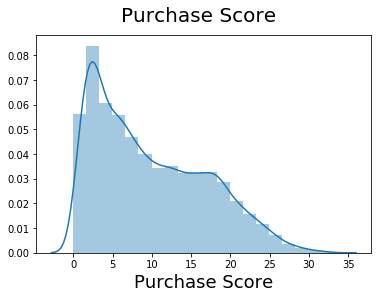

In [88]:
# Plot the histogram of the Purchase Score
fig = plt.figure()
sns.distplot((last_month_assortment_df.purchase_score_total), bins = 20)
fig.suptitle('Purchase Score', fontsize = 20)                  # Plot heading 
plt.xlabel('Purchase Score', fontsize = 18)                         # X-label

Text(0.5, 0, 'Purchase Score Product')

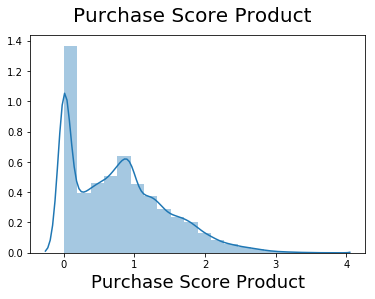

In [89]:
# Plot the histogram of the Purchase Score Product
fig = plt.figure()
sns.distplot((last_month_assortment_df.purchase_score_product), bins = 20)
fig.suptitle('Purchase Score Product', fontsize = 20)                  # Plot heading 
plt.xlabel('Purchase Score Product', fontsize = 18)                         # X-label

Text(0.5, 0, 'Purchase Score User')

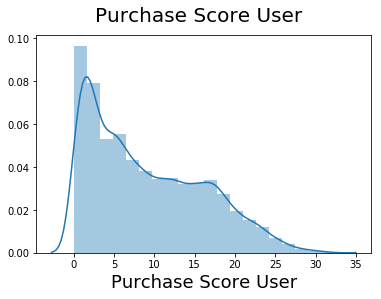

In [90]:
# Plot the histogram of the Purchase Score User
fig = plt.figure()
sns.distplot((last_month_assortment_df.purchase_score_user), bins = 20)
fig.suptitle('Purchase Score User', fontsize = 20)                  # Plot heading 
plt.xlabel('Purchase Score User', fontsize = 18)     

In [91]:
sum(last_month_assortment_df.purchase_score_user.isnull())

0

In [92]:
sum(last_month_assortment_df.purchase_score_user==0)

1412

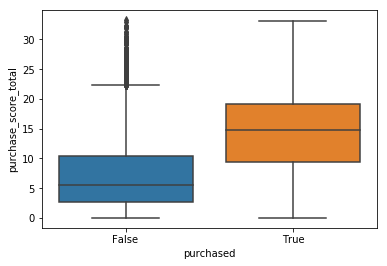

In [93]:
sns.boxplot(x='purchased', y='purchase_score_total',data=last_month_assortment_df)

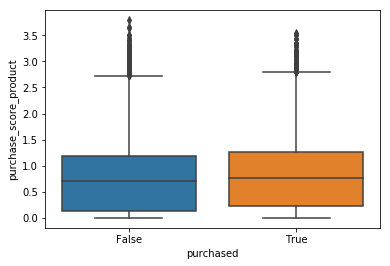

In [94]:
sns.boxplot(x='purchased', y='purchase_score_product',data=last_month_assortment_df)

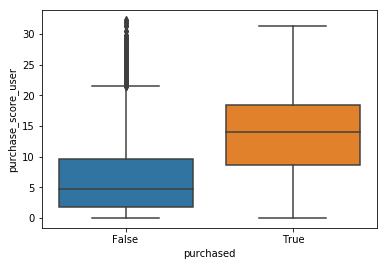

In [95]:
sns.boxplot(x='purchased', y='purchase_score_user',data=last_month_assortment_df)

Out of the purchase scores that we have calculated, product purchase scores dont show much difference for purchased and not purchased books.
But User puschase scores and hence total purchase scores show a substancial difference with user and total purchase scores being higher for purchased books.

So we can use purchase_score_user as one of the independent variables to feed our classification model.

#### Using Random Forests

Data Preparation for input to random forest model.

In [96]:
df_temp = pd.merge(df_temp, customer_features_df, how='inner', on='customer_id')
df_temp = pd.merge(df_temp, product_features_df, how='inner', on='product_id')
df_temp.head()

,customer_id,product_id,purchased,quantity_purchased,cost_to_buy,retail_value,total_cost_to_buy,purchased_price,send_shipping_cost,return_shipping_cost,age_bucket,is_returning_customer,favorite_genres,Likes_Self_Help,Likes_Biography,Likes_History,Likes_Thriller,Likes_Sci_Fi,Likes_Romance,Likes_Pop_Psychology,Likes_Beach_Read,Likes_Drama,Likes_Classic,Likes_Pop_Sci,length,difficulty,fiction,genre
0,1000078,1730073,False,81,1.74,10.21,140.94,0.0,0.6,0.6,46-55,True,"['Classic', 'History', 'Self-Help', 'Romance',...",1,0,1,1,1,1,1,1,0,1,1,219,4,True,Drama
1,1004863,1730073,False,81,1.74,10.21,140.94,0.0,0.6,0.6,36-45,True,"['Biography', 'Thriller', 'Pop-Psychology', 'R...",0,1,1,1,0,1,1,0,1,1,1,219,4,True,Drama
2,1023962,1730073,False,81,1.74,10.21,140.94,0.0,0.6,0.6,66+,True,"['Thriller', 'History', 'Drama', 'Biography', ...",1,1,1,1,1,1,1,0,1,1,1,219,4,True,Drama
3,1051139,1730073,False,81,1.74,10.21,140.94,0.0,0.6,0.6,18-25,True,"['History', 'Sci-Fi', 'Pop-Psychology', 'Roman...",1,0,1,1,1,1,1,0,0,0,0,219,4,True,Drama
4,1083822,1730073,False,81,1.74,10.21,140.94,0.0,0.6,0.6,46-55,False,"['Biography', 'Thriller', 'Pop-Psychology', 'R...",0,1,0,1,0,1,1,0,0,1,0,219,4,True,Drama


#### We only need the independent columns that have impact on the customers purchase decision
Dropping columns which I feel are irrelevant in this regard

In [97]:
df_temp.drop(['quantity_purchased','cost_to_buy','total_cost_to_buy','send_shipping_cost','return_shipping_cost','purchased_price','favorite_genres'],axis=1, inplace=True)

In [98]:
len(df_temp)

36000

In [99]:
df_temp.customer_id.nunique()

7200

In [100]:
#### Each of the 7200 customers have been sent 5 books thus
7200 * 5

36000

In [101]:
df_temp['purchase_score_user'] = last_month_assortment_df.purchase_score_user

In [102]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36000 entries, 0 to 35999
Data columns (total 22 columns):
customer_id              36000 non-null int64
product_id               36000 non-null int64
purchased                36000 non-null bool
retail_value             36000 non-null float64
age_bucket               34435 non-null object
is_returning_customer    36000 non-null bool
Likes_Self_Help          36000 non-null int64
Likes_Biography          36000 non-null int64
Likes_History            36000 non-null int64
Likes_Thriller           36000 non-null int64
Likes_Sci_Fi             36000 non-null int64
Likes_Romance            36000 non-null int64
Likes_Pop_Psychology     36000 non-null int64
Likes_Beach_Read         36000 non-null int64
Likes_Drama              36000 non-null int64
Likes_Classic            36000 non-null int64
Likes_Pop_Sci            36000 non-null int64
length                   36000 non-null int64
difficulty               36000 non-null int64
fiction         

In [103]:
#Dropping Customer rows with null age brackets below % data
(36000 - 34435)*100/36000

4.347222222222222

In [104]:
df_temp = df_temp[~df_temp.age_bucket.isnull()]

In [105]:
df_temp.drop(['customer_id','product_id'], inplace=True,axis=1)

#### Creating Dummy Variables

In [106]:
df_temp.head()

,purchased,retail_value,age_bucket,is_returning_customer,Likes_Self_Help,Likes_Biography,Likes_History,Likes_Thriller,Likes_Sci_Fi,Likes_Romance,Likes_Pop_Psychology,Likes_Beach_Read,Likes_Drama,Likes_Classic,Likes_Pop_Sci,length,difficulty,fiction,genre,purchase_score_user
0,False,10.21,46-55,True,1,0,1,1,1,1,1,1,0,1,1,219,4,True,Drama,1.813545
1,False,10.21,36-45,True,0,1,1,1,0,1,1,0,1,1,1,219,4,True,Drama,0.000000
2,False,10.21,66+,True,1,1,1,1,1,1,1,0,1,1,1,219,4,True,Drama,1.196996
3,False,10.21,18-25,True,1,0,1,1,1,1,1,0,0,0,0,219,4,True,Drama,12.164045
4,False,10.21,46-55,False,0,1,0,1,0,1,1,0,0,1,0,219,4,True,Drama,0.887936


In [107]:
# Defining the map function
def binary_map(x):
    return x.map({True: 1, False: 0})

In [108]:
varlist =  ['purchased', 'is_returning_customer', 'fiction']

df_temp[varlist] = df_temp[varlist].apply(binary_map)

In [109]:
dummy1 = pd.get_dummies(df_temp[['age_bucket', 'genre']], drop_first=True)

# Adding the results to the master dataframe
df_temp = pd.concat([df_temp, dummy1], axis=1)

In [110]:
df_temp.drop(['age_bucket', 'genre'],axis=1,inplace=True)

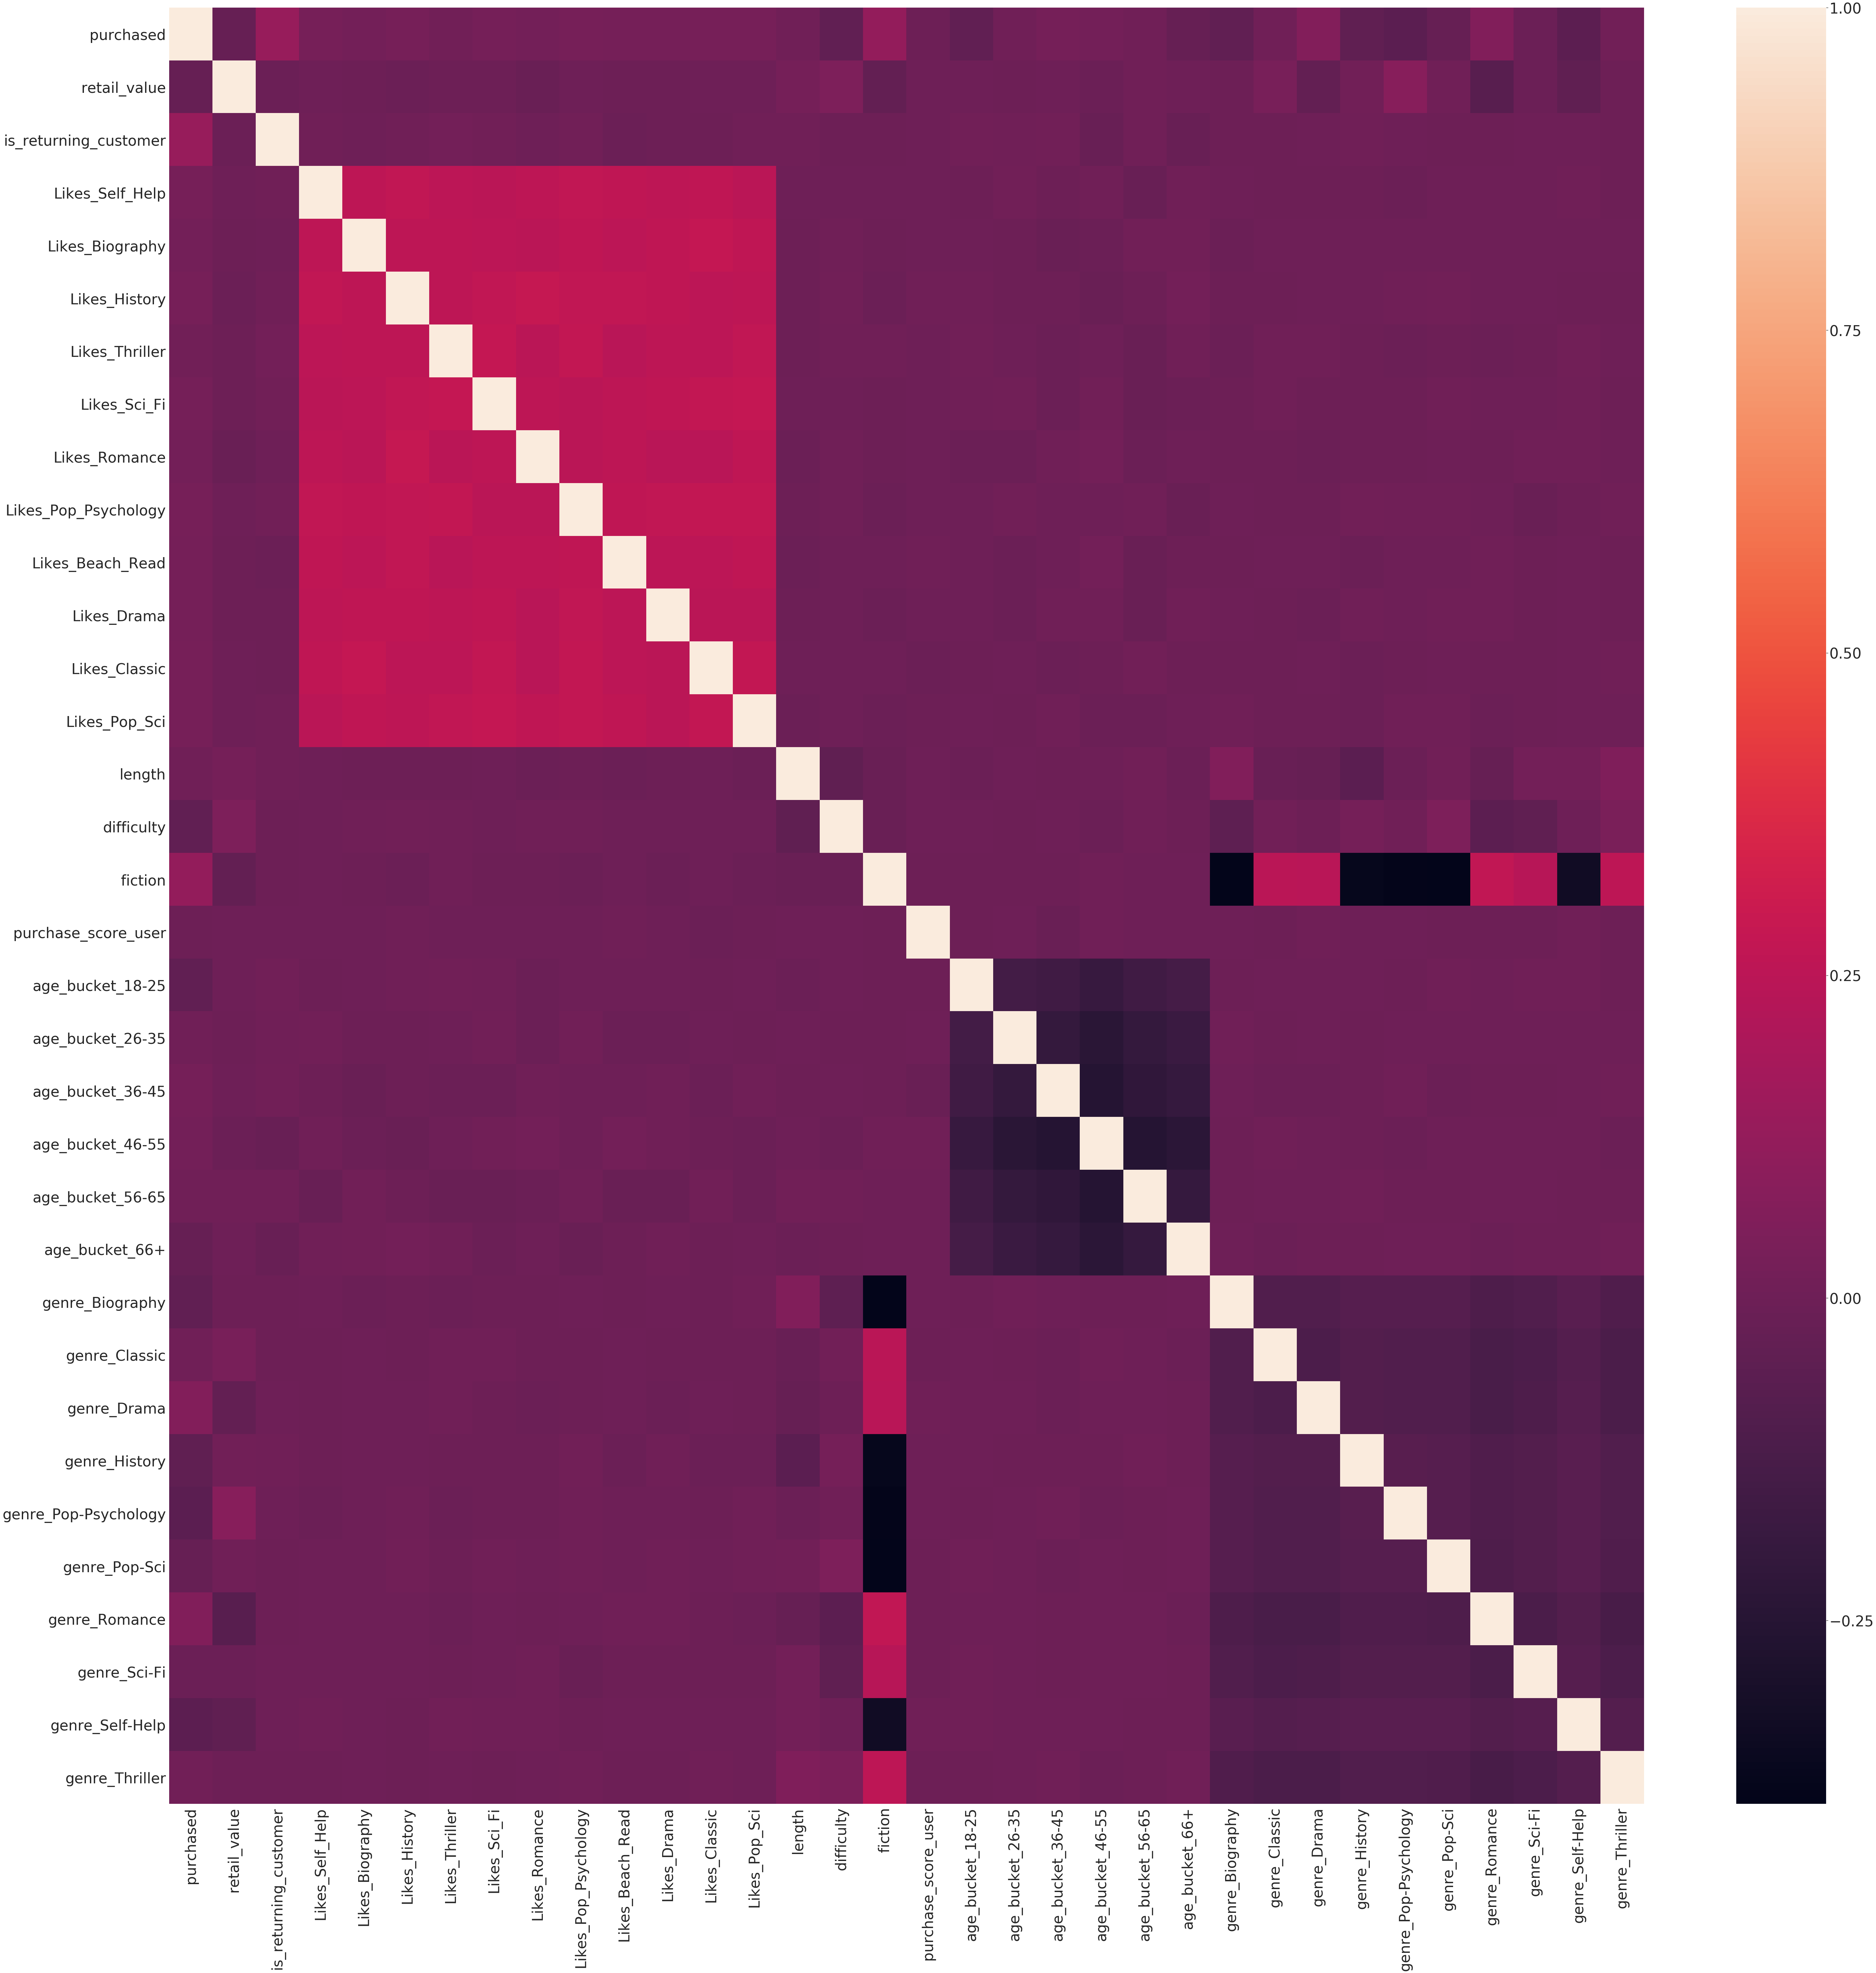

In [111]:
# Let's see the correlation matrix 
plt.figure(figsize = (100,100))        # Size of the figure
sns.set(font_scale=4)
corrmat = df_temp.corr()
sns.heatmap(df_temp.corr())
plt.show()

In [112]:
# Putting feature variable to X
X = df_temp.drop(['purchased'], axis=1)
y = df_temp['purchased']

#### Feature Scaling

In [113]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#X_train[['retail_value','length','difficulty','purchase_score_user']] = scaler.fit_transform(X_train[['retail_value','length','difficulty','purchase_score_user']])
X[['retail_value','length','difficulty','purchase_score_user']] = scaler.fit_transform(X[['retail_value','length','difficulty','purchase_score_user']])

#X_train.head()
X.head()

,retail_value,is_returning_customer,Likes_Self_Help,Likes_Biography,Likes_History,Likes_Thriller,Likes_Sci_Fi,Likes_Romance,Likes_Pop_Psychology,Likes_Beach_Read,Likes_Drama,Likes_Classic,Likes_Pop_Sci,length,difficulty,fiction,purchase_score_user,age_bucket_18-25,age_bucket_26-35,age_bucket_36-45,age_bucket_46-55,age_bucket_56-65,age_bucket_66+,genre_Biography,genre_Classic,genre_Drama,genre_History,genre_Pop-Psychology,genre_Pop-Sci,genre_Romance,genre_Sci-Fi,genre_Self-Help,genre_Thriller
0,-0.609314,1,1,0,1,1,1,1,1,1,0,1,1,-0.228096,0.761429,1,-1.021017,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,-0.609314,1,0,1,1,1,0,1,1,0,1,1,1,-0.228096,0.761429,1,-1.278222,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,-0.609314,1,1,1,1,1,1,1,1,0,1,1,1,-0.228096,0.761429,1,-1.108459,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,-0.609314,1,1,0,1,1,1,1,1,0,0,0,0,-0.228096,0.761429,1,0.446934,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,-0.609314,0,0,1,0,1,0,1,1,0,0,1,0,-0.228096,0.761429,1,-1.152291,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [114]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier


#### Below code convertedto markdown cells contains GridsSearchCV code to iteratively arrive at the optimal input parameters for Random Forest to achieve maximum consistency.
#### Commenting it and running the model only with final optimal parameters as runing the code again will take lot of time.

##### specify number of folds for k-fold CV
n_folds = 5

##### parameters to build the model on
parameters = {'max_depth': range(2, 50, 5)}

##### instantiate the model
rf = RandomForestClassifier()


##### fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True,
                   n_jobs=-1)
#rf.fit(X_train, y_train)
rf.fit(X, y)

##### scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

##### plotting accuracies with max_depth
plt.figure()
#plt.rcParams.update({'font.size': 0.5})
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


##### printing the optimal accuracy score and hyperparameters
best_score = rf.best_score_
best_hyperparams = rf.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

##### GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


##### specify number of folds for k-fold CV
n_folds = 5

##### parameters to build the model on
parameters = {'n_estimators': range(5, 200, 5)
             }

##### instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=12)


##### fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True,
                   n_jobs=-1)
rf.fit(X, y)

##### scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

##### plotting accuracies with max_depth
plt.figure()
#plt.rcParams.update({'font.size': 0.5})
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


##### printing the optimal accuracy score and hyperparameters
best_score = rf.best_score_
best_hyperparams = rf.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

##### GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


##### specify number of folds for k-fold CV
n_folds = 5

##### parameters to build the model on
parameters = {'max_features': [4,8,12,16,20,24,28,32]}

##### instantiate the model
rf = RandomForestClassifier(max_depth=12,
                            n_estimators=195
                           )


##### fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True,
                   n_jobs=-1)
rf.fit(X, y)

##### scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

##### plotting accuracies with max_depth
plt.figure()
#plt.rcParams.update({'font.size': 0.5})
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### printing the optimal accuracy score and hyperparameters
best_score = rf.best_score_
best_hyperparams = rf.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


##### specify number of folds for k-fold CV
n_folds = 5

##### parameters to build the model on
parameters = {'min_samples_leaf': range(2, 80, 2)}

##### instantiate the model
rf = RandomForestClassifier(max_depth=12,
                            n_estimators=195,
                            max_features=8
                            )


##### fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True,
                   n_jobs=-1)
rf.fit(X, y)

##### scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

##### plotting accuracies with max_depth
plt.figure()
#plt.rcParams.update({'font.size': 0.5})
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### printing the optimal accuracy score and hyperparameters
best_score = rf.best_score_
best_hyperparams = rf.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


##### specify number of folds for k-fold CV
n_folds = 5

##### parameters to build the model on
parameters = {'min_samples_split': range(2, 80, 2)}

##### instantiate the model
rf = RandomForestClassifier(max_depth=12,
                            n_estimators=195,
                            max_features=8,
                            min_samples_leaf=22
                            )


##### fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True,
                   n_jobs=-1)
rf.fit(X, y)

##### scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

##### plotting accuracies with max_depth
plt.figure()
#plt.rcParams.update({'font.size': 0.5})
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### printing the optimal accuracy score and hyperparameters
best_score = rf.best_score_
best_hyperparams = rf.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

### So optimal parameters below give mavimum sccuracy of 0.75.

max_depth=12

n_estimators=195,

max_features=8

min_samples_leaf=22

min_samples_split=10

#### Final model with optimal parameter values

In [115]:
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=12,
                             n_estimators=195,
                             max_features=8,
                             min_samples_leaf=22,
                             min_samples_split=10)

In [116]:
# fit
rfc.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=22, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=195,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Test data preparation

In [117]:
len(next_month_assortment_df)

56400

In [118]:
next_month_assortment_df.head()

,customer_id,product_id,purchased
0,1600785,1443029,False
1,1600785,1164138,False
2,1600785,1636511,False
3,1600785,1832547,False
4,1600785,1237420,False


Here we dont have user purchase score for these set of books, but we will calculate it based on previous purchases.

In [119]:
X.head()

,retail_value,is_returning_customer,Likes_Self_Help,Likes_Biography,Likes_History,Likes_Thriller,Likes_Sci_Fi,Likes_Romance,Likes_Pop_Psychology,Likes_Beach_Read,Likes_Drama,Likes_Classic,Likes_Pop_Sci,length,difficulty,fiction,purchase_score_user,age_bucket_18-25,age_bucket_26-35,age_bucket_36-45,age_bucket_46-55,age_bucket_56-65,age_bucket_66+,genre_Biography,genre_Classic,genre_Drama,genre_History,genre_Pop-Psychology,genre_Pop-Sci,genre_Romance,genre_Sci-Fi,genre_Self-Help,genre_Thriller
0,-0.609314,1,1,0,1,1,1,1,1,1,0,1,1,-0.228096,0.761429,1,-1.021017,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,-0.609314,1,0,1,1,1,0,1,1,0,1,1,1,-0.228096,0.761429,1,-1.278222,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,-0.609314,1,1,1,1,1,1,1,1,0,1,1,1,-0.228096,0.761429,1,-1.108459,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,-0.609314,1,1,0,1,1,1,1,1,0,0,0,0,-0.228096,0.761429,1,0.446934,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,-0.609314,0,0,1,0,1,0,1,1,0,0,1,0,-0.228096,0.761429,1,-1.152291,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [120]:
purchase_score_user1 = next_month_assortment_df.apply(lambda row: func_purchase_score(row,'user'),axis=1)

In [121]:
sum(purchase_score_user1.isnull())

0

In [122]:
sum(purchase_score_user1==0)

2474

This time we have 0 user purchase scores more users compared to earlier, due to some customers appearing for the first time in next assortment or who appeared in previous assortment but never purchased anything.

Text(0.5, 0, 'Purchase Score')

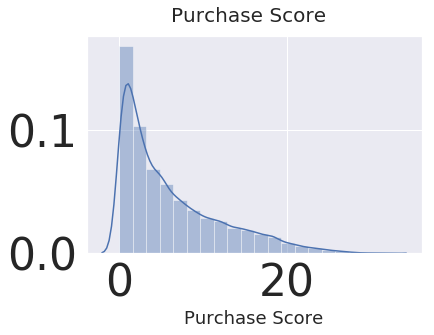

In [123]:
# Plot the histogram of the Purchase Score
fig = plt.figure()
sns.distplot((purchase_score_user1), bins = 20)
fig.suptitle('Purchase Score', fontsize = 20)                  # Plot heading 
plt.xlabel('Purchase Score', fontsize = 18)                         # X-label

In [124]:
next_month_assortment_df.purchased = next_month_assortment_df.purchased.apply(lambda x: 1 if x else 0)
#next_month_assortment_df['purchase_score_user'] = purchase_score_user1
next_month_assortment_df.head()


,customer_id,product_id,purchased
0,1600785,1443029,0
1,1600785,1164138,0
2,1600785,1636511,0
3,1600785,1832547,0
4,1600785,1237420,0


In [125]:
df_test_temp = pd.merge(next_month_assortment_df, original_purchase_order_df, how='inner', on='product_id')
df_test_temp = pd.merge(df_test_temp, customer_features_df, how='inner', on='customer_id')
df_test_temp = pd.merge(df_test_temp, product_features_df, how='inner', on='product_id')
df_test_temp.drop(['quantity_purchased','cost_to_buy','total_cost_to_buy','favorite_genres'],axis=1, inplace=True)
df_test_temp['purchase_score_user'] = purchase_score_user1
varlist =  ['purchased', 'is_returning_customer', 'fiction']
df_test_temp[varlist] = df_test_temp[varlist].apply(binary_map)
dummy1 = pd.get_dummies(df_test_temp[['age_bucket', 'genre']], drop_first=True)
# Adding the results to the master dataframe
df_test_temp = pd.concat([df_test_temp, dummy1], axis=1)
df_test_temp.drop(['age_bucket', 'genre','customer_id','product_id'],axis=1,inplace=True)
# Putting feature variable to X
X_test = df_test_temp.drop(['purchased'], axis=1)
y_test = df_test_temp['purchased']
X_test[['retail_value','length','difficulty','purchase_score_user']] = scaler.transform(X_test[['retail_value','length','difficulty','purchase_score_user']])
X_test.head()

,retail_value,is_returning_customer,Likes_Self_Help,Likes_Biography,Likes_History,Likes_Thriller,Likes_Sci_Fi,Likes_Romance,Likes_Pop_Psychology,Likes_Beach_Read,Likes_Drama,Likes_Classic,Likes_Pop_Sci,length,difficulty,fiction,purchase_score_user,age_bucket_18-25,age_bucket_26-35,age_bucket_36-45,age_bucket_46-55,age_bucket_56-65,age_bucket_66+,genre_Biography,genre_Classic,genre_Drama,genre_History,genre_Pop-Psychology,genre_Pop-Sci,genre_Romance,genre_Sci-Fi,genre_Self-Help,genre_Thriller
0,0.277056,0,1,1,1,1,1,1,1,0,0,1,1,-0.227878,-0.982527,1,-0.451642,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.277056,1,1,1,1,1,0,1,0,1,0,0,0,-0.227878,-0.982527,1,0.081284,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0.277056,1,0,0,0,0,0,0,0,0,0,0,0,-0.227878,-0.982527,1,-0.118367,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0.277056,0,0,0,0,0,0,0,0,0,0,0,0,-0.227878,-0.982527,1,-0.653516,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.277056,1,0,1,0,0,0,0,1,1,0,1,1,-0.227878,-0.982527,1,0.136482,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [126]:
X.head()

,retail_value,is_returning_customer,Likes_Self_Help,Likes_Biography,Likes_History,Likes_Thriller,Likes_Sci_Fi,Likes_Romance,Likes_Pop_Psychology,Likes_Beach_Read,Likes_Drama,Likes_Classic,Likes_Pop_Sci,length,difficulty,fiction,purchase_score_user,age_bucket_18-25,age_bucket_26-35,age_bucket_36-45,age_bucket_46-55,age_bucket_56-65,age_bucket_66+,genre_Biography,genre_Classic,genre_Drama,genre_History,genre_Pop-Psychology,genre_Pop-Sci,genre_Romance,genre_Sci-Fi,genre_Self-Help,genre_Thriller
0,-0.609314,1,1,0,1,1,1,1,1,1,0,1,1,-0.228096,0.761429,1,-1.021017,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,-0.609314,1,0,1,1,1,0,1,1,0,1,1,1,-0.228096,0.761429,1,-1.278222,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,-0.609314,1,1,1,1,1,1,1,1,0,1,1,1,-0.228096,0.761429,1,-1.108459,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,-0.609314,1,1,0,1,1,1,1,1,0,0,0,0,-0.228096,0.761429,1,0.446934,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,-0.609314,0,0,1,0,1,0,1,1,0,0,1,0,-0.228096,0.761429,1,-1.152291,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [127]:
y_test = rfc.predict(X_test)

In [128]:
next_month_assortment_df['purchased_predicted'] = y_test

In [129]:
next_month_assortment_df

,customer_id,product_id,purchased,purchased_predicted
0,1600785,1443029,0,0
1,1600785,1164138,0,0
2,1600785,1636511,0,0
3,1600785,1832547,0,0
4,1600785,1237420,0,0
5,1600852,1597824,0,0
6,1600852,1755017,0,0
7,1600852,1267131,0,0
8,1600852,1516839,0,0
9,1600852,1833307,0,0


#### Profits predicted to be earned in next month assortment based on predicted purchased values.

In [130]:
df_pred = pd.merge(next_month_assortment_df, original_purchase_order_df, how='inner', on='product_id')
df_pred['purchased_price'] = df_pred.apply(lambda row: row.retail_value if row.purchased else 0, axis=1)
df_pred['send_shipping_cost'] = 0.60
df_pred['return_shipping_cost'] = df_pred.purchased.apply(lambda x: 0.60 if not x else 0)

In [131]:
predicted_revenue_next_assortment = df_pred.purchased_price.sum() - (df_pred.send_shipping_cost + df_pred.return_shipping_cost).sum()
predicted_revenue_next_assortment

-67679.99999999997

#### Will we be able to both pay back our loan and afford our next book purchase order?

In [132]:
if predicted_revenue_next_assortment - loan_pending >= total_spending_reqd_next_mnth_purchase:
    print('Yes we will be able to pay back our loan and afford our next book purchase order')
else:
    print('No we will not be able to pay back our loan and afford our next book purchase order')
    
print('Initial Loan Amount: '+ str(initial_loan_amount))
print('Total revenue Last Month Assortment: '+ str(total_revenue_last_mnth_assortment))
print('Profit Earned Last Month Assortment(): '+ str(profit_earned_last_month))
print('Loan Pending: '+ str(loan_pending))
print('Predicted revenue Next Month Assortment: '+str(predicted_revenue_next_assortment))
print('Total Spending required for Next Month Purchase: '+str(total_spending_reqd_next_mnth_purchase))

No we will not be able to pay back our loan and afford our next book purchase order
Initial Loan Amount: 135546.42
Total revenue Last Month Assortment: 116024.76
Profit Earned Last Month Assortment(): -19521.66
Loan Pending: 19521.66
Predicted revenue Next Month Assortment: -67679.99999999997
Total Spending required for Next Month Purchase: 24155.51


In [133]:
import sys
sys.stdout.write('***************Final Results************* \n')
if predicted_revenue_next_assortment - loan_pending >= total_spending_reqd_next_mnth_purchase:
    os.system('echo Yes we will be able to pay back our loan and afford our next book purchase order \n')
else:
    os.system('echo No we will not be able to pay back our loan and afford our next book purchase order \n')
    
os.system('echo Initial Loan Amount: '+ str(initial_loan_amount))
os.system('echo Total revenue Last Month Assortment: '+ str(total_revenue_last_mnth_assortment))
os.system('echo Profit Earned Last Month Assortment(): '+ str(profit_earned_last_month))
os.system('echo Loan Pending: '+ str(loan_pending))
os.system('echo Predicted revenue Next Month Assortment: '+str(predicted_revenue_next_assortment))
os.system('echo Total Spending required for Next Month Purchase: '+str(total_spending_reqd_next_mnth_purchase))

***************Final Results************* 


0